<a href="https://colab.research.google.com/github/SteveParadox/Agric_ai/blob/main/Tomato_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [3]:
IMAGE_SIZE

256

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/Agric_AI/PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 4373 files belonging to 6 classes.


In [6]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [7]:
d = len(dataset)
print(d)

137


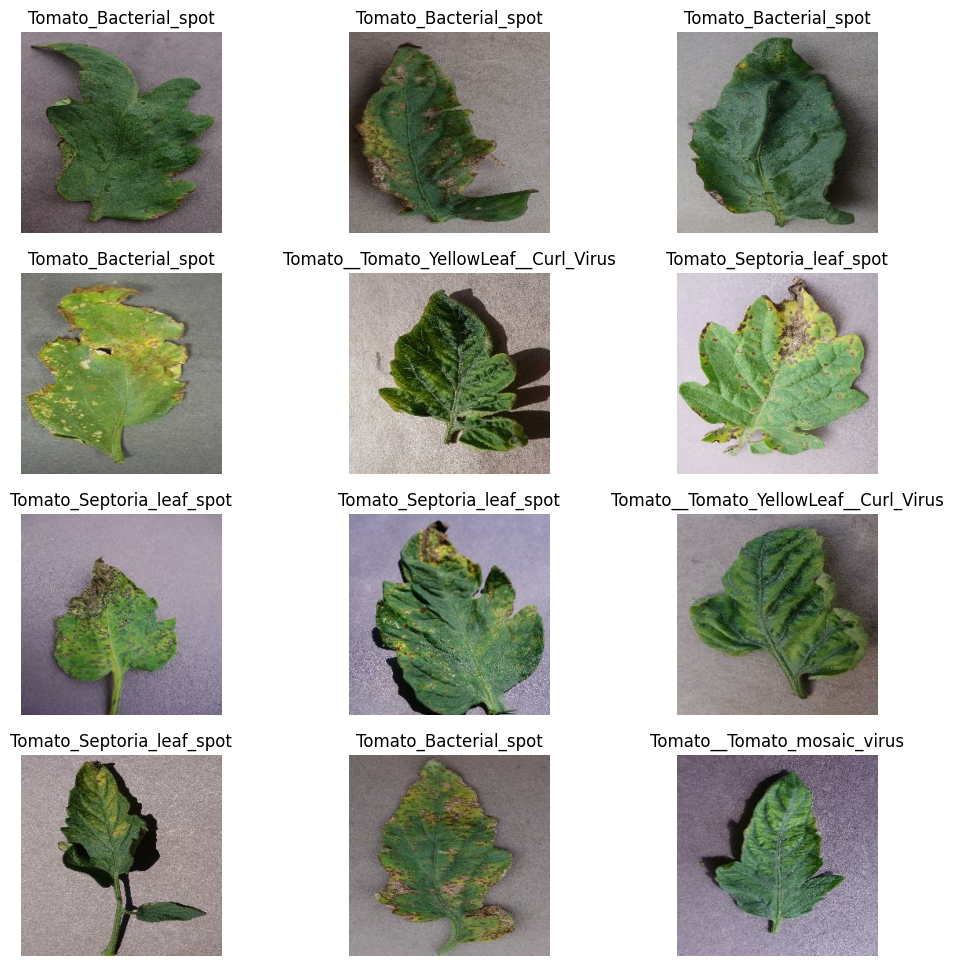

In [8]:
plt.figure(figsize=(12, 12))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
train_size = 0.8
train = len(dataset)*train_size
train

109.60000000000001

In [10]:
train_ds = dataset.take(int(train))
len(train_ds)

109

In [11]:
test_ds = dataset.skip(int(train))
len(test_ds)

28

In [12]:
val_size = 0.1
val = len(dataset)*val_size

In [13]:
val_ds = test_ds.take(int(val))
len(val_ds)

13

In [14]:
test_ds = test_ds.skip(int(val))
len(test_ds)

15

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_size=0.1,
                              shuffle=True, shuffle_size = 10000 ):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

109

In [18]:
len(val_ds)

13

In [19]:
len(test_ds)

15

In [20]:
# Making the training faster by simultanously using the GPU and CPU
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

n_classes = len(class_names)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(n_classes, activation='softmax')

])
model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [25]:
model.compile(
optimizer="adam",
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [26]:
history = model.fit(
train_ds,
epochs=EPOCHS,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds
)

Epoch 1/20
109/109 [==============================] - 1078s 4s/step - loss: 1.3430 - accuracy: 0.4553 - val_loss: 1.4514 - val_accuracy: 0.5409
Epoch 2/20
109/109 [==============================] - 446s 4s/step - loss: 0.6456 - accuracy: 0.7627 - val_loss: 1.1895 - val_accuracy: 0.6827
Epoch 3/20
109/109 [==============================] - 450s 4s/step - loss: 0.5051 - accuracy: 0.8246 - val_loss: 1.0754 - val_accuracy: 0.6851
Epoch 4/20
109/109 [==============================] - 448s 4s/step - loss: 0.4405 - accuracy: 0.8435 - val_loss: 1.0038 - val_accuracy: 0.7524
Epoch 5/20
109/109 [==============================] - 437s 4s/step - loss: 0.3371 - accuracy: 0.8786 - val_loss: 0.9235 - val_accuracy: 0.7548
Epoch 6/20
109/109 [==============================] - 443s 4s/step - loss: 0.2782 - accuracy: 0.9045 - val_loss: 1.2513 - val_accuracy: 0.7452
Epoch 7/20
109/109 [==============================] - 435s 4s/step - loss: 0.2574 - accuracy: 0.9074 - val_loss: 0.7295 - val_accuracy: 0.819

In [27]:
history.history

{'loss': [1.3430371284484863,
  0.6455828547477722,
  0.5050785541534424,
  0.4404761791229248,
  0.337102472782135,
  0.2782115936279297,
  0.2573753595352173,
  0.2942723035812378,
  0.19525344669818878,
  0.234772190451622,
  0.16438117623329163,
  0.19082950055599213,
  0.18846772611141205,
  0.1627652794122696,
  0.14472363889217377,
  0.16707687079906464,
  0.15682180225849152,
  0.12531238794326782,
  0.13373957574367523,
  0.14546209573745728],
 'accuracy': [0.45527753233909607,
  0.7627264857292175,
  0.8245614171028137,
  0.843543291091919,
  0.8786309957504272,
  0.9045153856277466,
  0.9073914289474487,
  0.9019269347190857,
  0.9303997755050659,
  0.9188956022262573,
  0.9416163563728333,
  0.9329882264137268,
  0.9324129819869995,
  0.9436295628547668,
  0.9456427693367004,
  0.9401783347129822,
  0.9473684430122375,
  0.9577221870422363,
  0.9508196711540222,
  0.9459304213523865],
 'val_loss': [1.451407790184021,
  1.1894900798797607,
  1.0753769874572754,
  1.003752946

In [28]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 28s 997ms/step - loss: 0.9176 - accuracy: 0.8229


In [ ]:
scores

In [ ]:
history.params

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

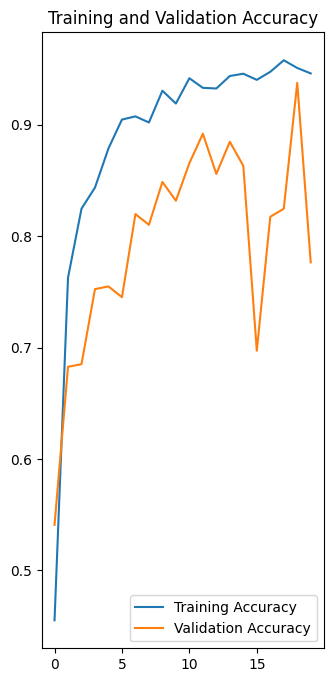

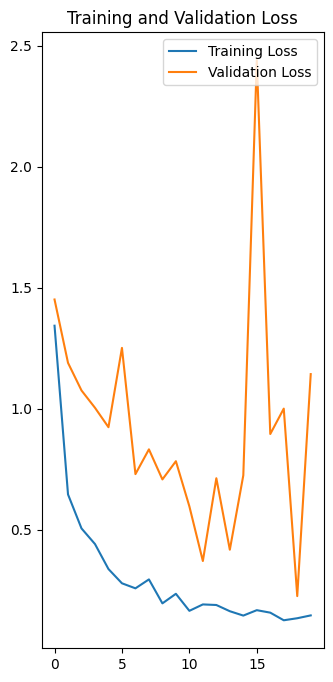

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first image actual label: Tomato_Spider_mites_Two_spotted_spider_mite
1/1 [==============================] - 2s 2s/step
predicted label: Tomato_healthy


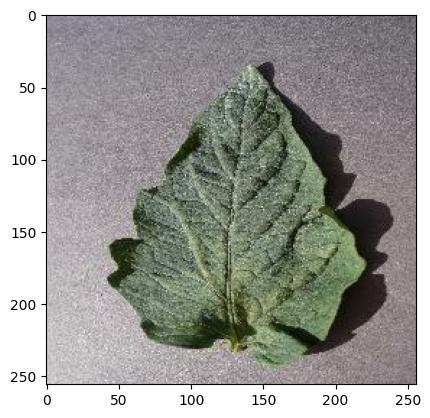

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print('first image to predict')
    plt.imshow(first_image)
    print('first image actual label:', class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print('predicted label:', class_names[np.argmax(batch_prediction[0])])


In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 48ms/step


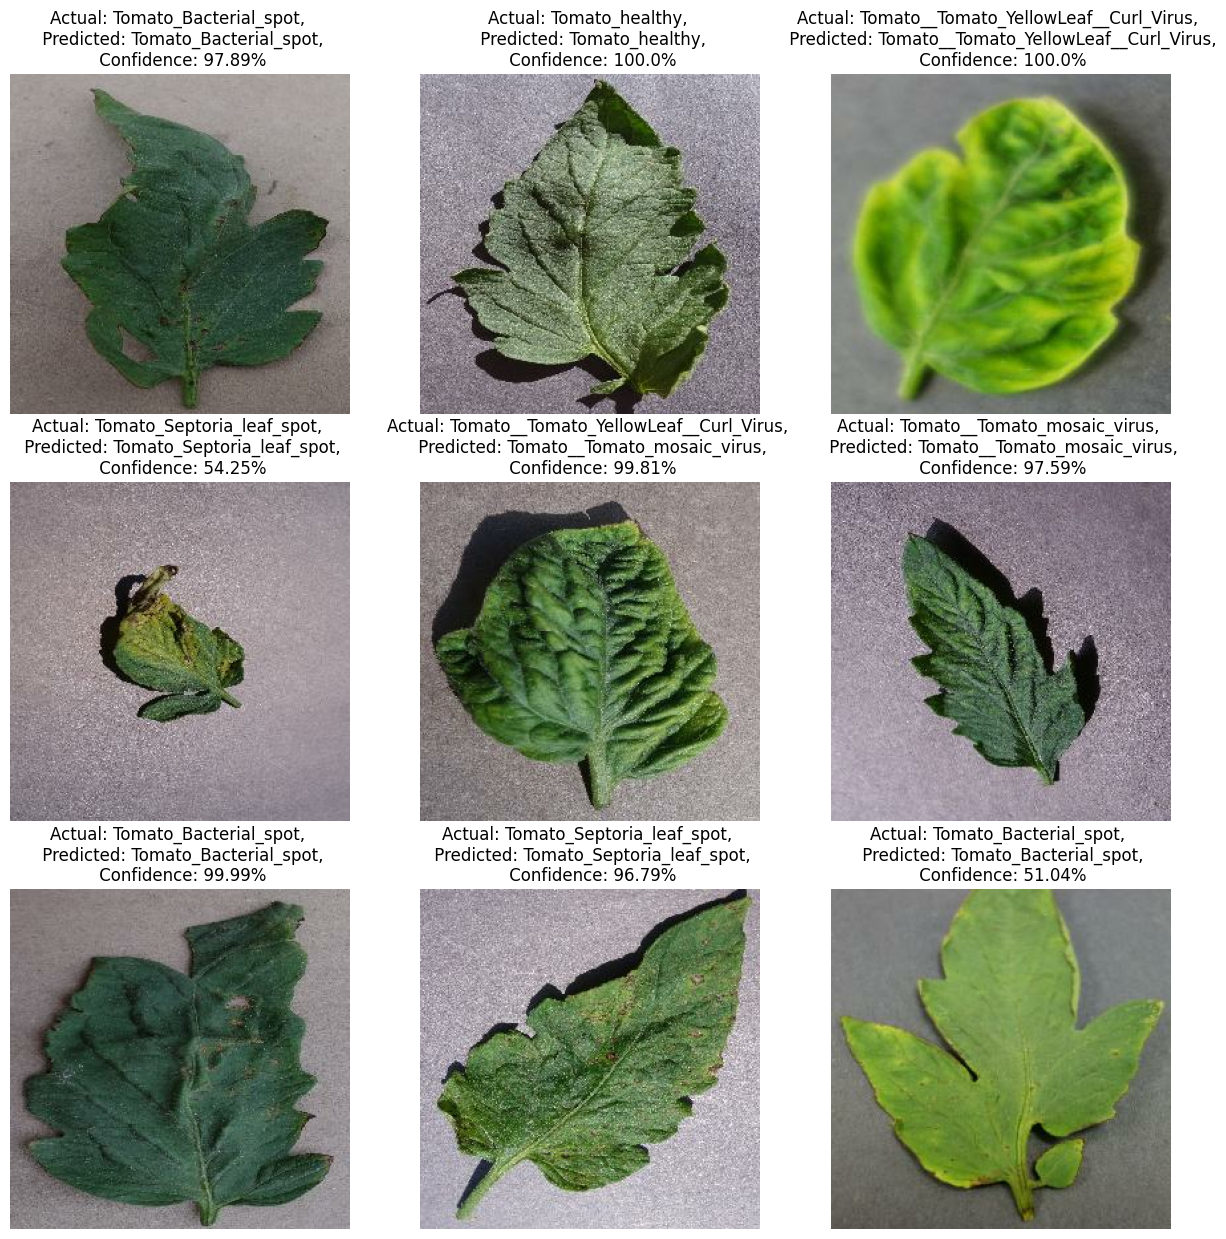

In [47]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class},\n Confidence: {confidence}%")
        plt.axis('off')

In [37]:
print(tf.__version__)

2.12.0


In [43]:
import os
model_version = max([int(i) for i in os.listdir("/content/drive/MyDrive/Agric_AI/Models") + [0]])+1
model_path = f"/content/drive/MyDrive/Agric_AI/Models/{model_version}"

model.save(model_path)




In [39]:
model.save("/content/drive/MyDrive/Agric_AI/tomatoes.h5")